<a href="https://colab.research.google.com/github/hamidreza2015/pythorch_experiences/blob/master/UNET_Potsdam_Tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Potsdam_Tiny.zip"

In [0]:
import os
import argparse
import shutil
import yaml
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

from torch.utils import data
from tqdm import tqdm


from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
        
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))
        
class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
        
def label_to_color(arr_2d):
       
    palette =  {0:(255, 255, 255),    # Impervious_surfaces
                1:(0,     0, 255),    # Building
                2:(0,   255, 255),    # Low_vegetation
                3:(0,   255,   0),    #Tree
                4:(255, 255,   0),    #Car
                5:(255,   0,   0)}    #Clutter
        
    arr_3d = np.zeros((arr_2d.shape[0] , arr_2d.shape[1] , 3) , dtype=np.uint8)
    
    for c,i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i
    return arr_3d

def CrossEntropyLoss2d(input, target, weight=None):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, reduction='mean', ignore_index=250
    )
    return loss

In [5]:
print(torch.__version__)
print(torchvision.__version__)

1.1.0
0.3.0


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
import torchvision.transforms.functional as TF
import collections
import imageio

class PotsdamLoader(data.Dataset):
    def __init__(
        self, 
        root, 
        split = 'train', 
        is_transform = False,
        img_size = None, 
        augmentations = None,
        img_norm = True,
        test_mode=False):
        
        self.root = root
        self.split = split
        self.img_size = [224,224]
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        
        self.n_classes = 6
        self.files = collections.defaultdict(list)
        
        for split in ['Train', 'Test', 'Val']:
            file_list = os.listdir(root + '/' + split + '/' + 'RGB')
            self.files[split] = file_list
            
    def __len__(self):
        return len(self.files[self.split])
        
        
    def __getitem__(self,index):
        
        image_name = self.files[self.split][index]
        #label_name = image_name.replace('RGB' , 'label')
        
        image_path = self.root + '/' + self.split + '/' + 'RGB' + '/' + image_name
        label_path = image_path.replace('RGB','Label')
        
        #label_path = self.root + '/' + self.split + '/' + 'label' + '/' + label_name
        
        image = imageio.imread(image_path)
        image = np.array(image ,dtype=np.uint8)
        
        label = imageio.imread(label_path)
        label = color_to_label(label)
        label = np.array(label)
        
        
        
        
        if self.is_transform:
            img , lbl = self.transform(image , label)

        return img , lbl    
        
    def transform(self, img , lbl):
        #img = m.imresize(img, (self.img_size[0], self.img_size[1])) 
        
        #img = img.astype(np.float64)
        #img -= self.mean
        
                       
        if self.img_norm:
            img = TF.to_tensor(img)
            
        #img = img.transpose(2,0,1)
        
        #img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        return img , lbl
    
    
def color_to_label(arr_3d):
    
    palette =  {0:(255, 255, 255),    # Impervious_surfaces
                1:(0,     0, 255),    # Building
                2:(0,   255, 255),    # Low_vegetation
                3:(0,   255,   0),    #Tree
                4:(255, 255,   0),    #Car
                5:(255,   0,   0)}    #Clutter
    invert_palette = {v: k for k, v in palette.items()}
    
    arr_2d = np.zeros((arr_3d.shape[0] , arr_3d.shape[1]) , dtype=np.uint8)
    
    for c,i in invert_palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1,1,3),axis=2)
        arr_2d[m] = i
        
    return arr_2d

In [8]:
data_loader = PotsdamLoader
data_path = '/content/Potsdam_Tiny'

train_dataset = data_loader(
        data_path,
        is_transform=True,
        split='Train',
        img_size=[224,224],
            )

val_dataset = data_loader(
        data_path,
        is_transform=True,
        split='Val',
        img_size=[224,224],
            )

print('train_lengh= ',len(train_dataset) , '  val_lengh= ',len(val_dataset))

train_lengh=  2001   val_lengh=  400


In [0]:
n_classes = train_dataset.n_classes

batch_size = 16

trainloader = data.DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=0,
                              shuffle=True)
    
valloader = data.DataLoader(val_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle=False)

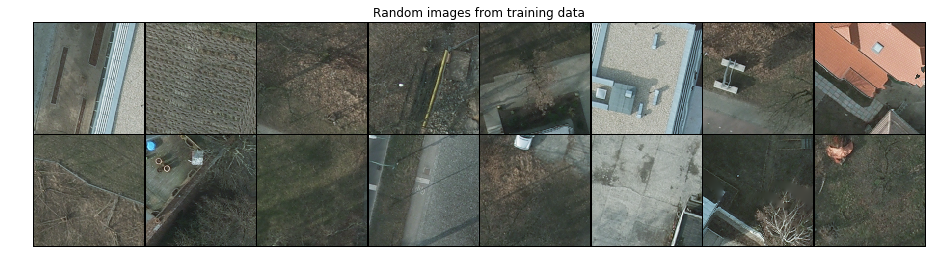

In [0]:
inputs, targets = next(iter(trainloader))
out_image = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out_image ,title= 'Random images from training data')

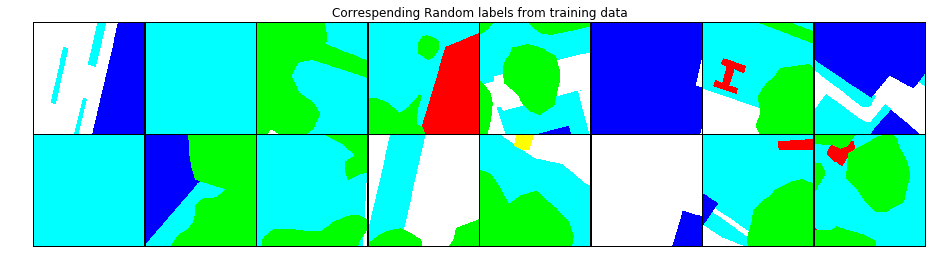

In [0]:
out_labeln = targets.numpy()
out_label = np.zeros((out_labeln.shape[0] , 3 , out_labeln[1,:,:].shape[0] ,out_labeln[1,:,:].shape[1] ) , dtype=np.uint8)
for i in range(out_labeln.shape[0]):
    temp = label_to_color(out_labeln[i,:,:])
    temp = temp.transpose(2,0,1)
    out_label[i,:,:,:] = temp
    
out_label = torch.from_numpy(out_label)
out_label = torchvision.utils.make_grid(out_label, padding=3)
plt.figure(figsize=(16, 12))
imshow(out_label ,title= 'Correspending Random labels from training data')

In [0]:
def conv3x3(in_channel, out_channel):
    return nn.Conv2d(in_channel, 
                     out_channel, 
                     kernel_size=3,
                     padding=1)

class ConvRelu(nn.Module):
    def __init__(self,
                in_channel,
                out_channel):
        super().__init__()
        
        self.conv = conv3x3(in_channel , out_channel)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self,
                in_channel,
                middle_channel,
                out_channel):
        super().__init__()
        
        self.block = nn.Sequential(
             ConvRelu(in_channel, middle_channel),
             nn.ConvTranspose2d(middle_channel, 
                                out_channel,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
             nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.block(x)

class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 6, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)

In [10]:
model = UNet11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:16<00:00, 32713118.57it/s]


In [0]:
model = model.to(device)

In [0]:
train_args = {
    'epoch_num': 100,
    'lr': 1e-2,
    'weight_decay': 1e-4,
    'momentum': 0.95,
    'lr_patience': 40,  # large patience denotes fixed lr
    'snapshot': '',  # empty string denotes learning from scratch
    'print_freq': 40,
    'val_save_to_img_file': False,
    'val_img_sample_rate': 0.1  # randomly sample some validation results to display
}
model.train()

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

params_dict = dict(model.named_parameters())
params = []

for key, value in params_dict.items():
    if 'd' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': train_args['lr']}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': train_args['lr'] / 2}]

if len(train_args['snapshot']) == 0:
    curr_epoch = 1
    train_args['best_record'] = {'epoch': 0, 'val_loss': 1e10, 'acc': 0, 'acc_cls': 0, 'mean_iu': 0, 'fwavacc': 0}

optimizer = optim.SGD(model.parameters(), lr=train_args['lr'], momentum=train_args['momentum'])
                       
criterion = CrossEntropyLoss2d

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=train_args['lr_patience'], min_lr=1e-10, verbose=True)

In [0]:
def train(train_loader, net, criterion, optimizer, epoch, train_args):
    train_loss = averageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        assert inputs.size()[2:] == labels.size()[1:]
        N = inputs.size(0)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        assert outputs.size()[2:] == labels.size()[1:]
        assert outputs.size()[1] == n_classes

        loss = criterion(outputs, labels) / N
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), N)

        curr_iter += 1
        writer.add_scalar('train_loss', train_loss.avg, curr_iter)

        if (i + 1) % train_args['print_freq'] == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg
            ))

def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist
  
def evaluate(predictions, gts, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(predictions, gts):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    # axis 0: gt, axis 1: prediction
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc
  
def validate(val_loader, net, criterion, optimizer, epoch, train_args ):
    net.eval()
  
    val_loss_meter = averageMeter()
    inputs_all, gts_all, predictions_all = [], [], []
  
    with torch.no_grad():
        for i_val , data in enumerate(val_loader):
          inputs, labels = data
          N = inputs.size(0)
      
          inputs = inputs.to(device)
          labels = labels.to(device)
      
          outputs = net(inputs)
          val_loss = criterion(input=outputs, target=labels)
      
          predictions = outputs.data.max(1)[1].cpu().numpy() 
      
          val_loss_meter.update(val_loss.item()/N , N)
      
          if random.random() > train_args['val_img_sample_rate']:
              inputs_all.append(None)
          else:
              inputs_all.append(inputs.data.cpu())
        
          gts_all.append(labels.data.cpu().numpy())
          predictions_all.append(predictions)

      
    acc, acc_cls, mean_iu, fwavacc = evaluate(predictions_all, gts_all, n_classes)
      
    
    if mean_iu > train_args['best_record']['mean_iu']:
        train_args['best_record']['val_loss'] = val_loss_meter.avg
        train_args['best_record']['epoch'] = epoch
        train_args['best_record']['acc'] = acc
        train_args['best_record']['acc_cls'] = acc_cls
        train_args['best_record']['mean_iu'] = mean_iu
        train_args['best_record']['fwavacc'] = fwavacc
        
        torch.save(net.state_dict(), 'model_UNet.pth')
        torch.save(optimizer.state_dict(), 'optimizer_UNet_param.pth')
        
    
    
    print('--------------------------------------------------------------------')
    
    print('[epoch %d], [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f]' % (
        epoch, val_loss_meter.avg, acc, acc_cls, mean_iu, fwavacc))
    
    print('best record: [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f], [epoch %d]' % (
        train_args['best_record']['val_loss'], train_args['best_record']['acc'], train_args['best_record']['acc_cls'],
        train_args['best_record']['mean_iu'], train_args['best_record']['fwavacc'], train_args['best_record']['epoch']))
      
    print('--------------------------------------------------------------------')
    
    writer.add_scalar('val_loss', val_loss_meter.avg, epoch)
    writer.add_scalar('acc', acc, epoch)
    writer.add_scalar('acc_cls', acc_cls, epoch)
    writer.add_scalar('mean_iu', mean_iu, epoch)
    writer.add_scalar('fwavacc', fwavacc, epoch)
    #writer.add_scalar('lr', optimizer.param_groups[1]['lr'], epoch)
    
    net.train()
    
    return val_loss_meter.avg

In [17]:
writer = SummaryWriter()

for epoch in range(curr_epoch, train_args['epoch_num'] + 1):
    train(trainloader, model, criterion, optimizer, epoch, train_args)
    val_loss = validate(valloader, model, criterion, optimizer, epoch, train_args)
    scheduler.step(val_loss)

[epoch 1], [iter 40 / 126], [train loss 0.10629]
[epoch 1], [iter 80 / 126], [train loss 0.10371]
[epoch 1], [iter 120 / 126], [train loss 0.10198]
--------------------------------------------------------------------
[epoch 1], [val loss 0.09442], [acc 0.38427], [acc_cls 0.16667], [mean_iu 0.06404], [fwavacc 0.14766]
best record: [val loss 0.09442], [acc 0.38427], [acc_cls 0.16667], [mean_iu 0.06404], [fwavacc 0.14766], [epoch 1]
--------------------------------------------------------------------
[epoch 2], [iter 40 / 126], [train loss 0.09356]
[epoch 2], [iter 80 / 126], [train loss 0.09441]
[epoch 2], [iter 120 / 126], [train loss 0.09412]
--------------------------------------------------------------------
[epoch 2], [val loss 0.08741], [acc 0.38427], [acc_cls 0.16667], [mean_iu 0.06404], [fwavacc 0.14766]
best record: [val loss 0.09442], [acc 0.38427], [acc_cls 0.16667], [mean_iu 0.06404], [fwavacc 0.14766], [epoch 1]
---------------------------------------------------------------